## Model Improvement

Summarize the setup and the model from the previous experiment:

#### Context
The code describes a predictive modeling setup to predict price changes over the next 10 hours based on some given features. 
The potential outcomes are:
- **+1**: The price will increase by more than +1% from the current close.
- **-1**: The price will decrease by more than -1% from the current close.
- **0**: The price change will be within +- 1% of the current close.

#### Model Structure

##### Data Preprocessing
- **Features and Targets**: Dropped 'datetime' and 'target' from features, used 'target' as label.
- **Train-Test Split**: 70% training and 30% test data.
- **Scaling**: Applied Standard Scaler to normalize feature data.
- **Handling Class Imbalance**: Used SMOTE to resample the minority class.

##### Base Models for Ensemble
1. **K-Nearest Neighbors**: A simple model for classification based on closest data points in the feature space.
2. **LightGBM**: A gradient boosting framework that uses tree-based learning algorithms.
3. **Bagging with Random Forest**: A Bagging model using RandomForest as the base estimator.
4. **Bagging with Decision Tree**: Another Bagging model but using Decision Tree as the base estimator.

##### Ensemble Strategy
- **Stacking Classifier**: Used as the final model.
    - **Base Estimators**: KNN, LightGBM, Bagging with RandomForest, and Bagging with Decision Tree.
    - **Final Estimator**: Logistic Regression.

##### Model Training
- The final stacking model is trained on the resampled (SMOTE) and scaled training data.
  
##### Evaluation Metrics (on Training Data with Cross-Validation)
- **Stacking with Logistic Regression as Final Estimator**: Mean Accuracy: 88.01%, Standard Deviation: 0.0286

##### Performance on Unseen Data
- The model was also tested on unseen data, with an overall accuracy of 78%.

##### Solution for problem with unseen data
- **Overfitting** The model may have overfit to the training data, learning the noise in the training data, but not the actual relationship between the variables.
- **Solution** Try simplifying the model, for example by reducing the number of features or changing hyperparameters.


### Current Model

In [92]:
import pandas as pd
import warnings

# Ref from data exploration
def remove_outlier(df, iqr_threshold = 5):
    
    # Calculate the first quartile (25th percentile) and third quartile (75th percentile)
    q1 = df['volume'].quantile(0.25)
    q3 = df['volume'].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    lower_bound = 0 if lower_bound < 0 else lower_bound

    # remove outliers from df
    df = df[(df['volume'] > lower_bound) & (df['volume'] < upper_bound)]
    
    return df

def read_hist_data(name = 'BTC', timeframe = '1h'):
    file_path = f"./data/{name}_USDT-{timeframe}.json"
    df = pd.read_json(file_path)

    # set column names
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

    # convert unix timestamp to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    
    df = remove_outlier(df)
    return df

import talib
import numpy as np
import warnings



def get_features(df):

    # List of periods
    periods = [4, 12, 24, 48, 100, 200]
    inputs = ['high', 'low', 'close', 'volume']

    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
            # Generate indicators

            # % of change
            df[f'{input}_pct_{period}'] = df[input].pct_change(periods=period) * 100

            # % of ema
            pct_ema = talib.EMA(df[input].values, timeperiod=period)
            df[f'{input}_ema_{period}'] = (df[input] - pct_ema) / pct_ema * 100

            # RSI
            df[f'{input}_rsi_{period}'] = talib.RSI(df[input].values, timeperiod=period)

            # TRIX
            df[f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            pct_sd = talib.STDDEV(df[input].values, timeperiod=period)
            df[f'{input}_sd_{period}'] = pct_sd / df[input] * 100

            # ROC
            df[f'{input}_roc_{period}'] = talib.ROC(df[input].values, timeperiod=period)

            # VAR
            df[f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)

            # Lagged

            # pct change - lagged 1
            df[f'{input}_lag1_{period}'] = df[f'{input}_pct_{period}'].shift(1)

            # pct change - lagged 2
            df[f'{input}_lag2_{period}'] = df[f'{input}_pct_{period}'].shift(2)

            


        
        # Multiple inputs indicators
        # ATR
        pct_atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df[f'price_atr_{period}'] = pct_atr / df['close'] * 100

        # Price interaction Features:
        df[f'price_interact_{period}'] = df[f'close_roc_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df[f'pv_interact_{period}'] = df[f'close_roc_{period}'] * df[f'volume_roc_{period}']

        # ADX
        df[f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df[f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df[f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

    return df

# to predict if the price will go up (+1%) or down (-1%) in the next 10 periods
def get_target_next_close(df, target_shift = 10):

    target_treshold = 0.01
    conditions = [
        (df['close'].shift(target_shift * -1).isnull()), 
        (df['close'].shift(target_shift * -1) > df['close'] * (1+target_treshold )),
        (df['close'].shift(target_shift * -1) < df['close'] * (1-target_treshold)),
        (df['close'].shift(target_shift * -1) >= df['close'] * (1-target_treshold)) & 
        (df['close'].shift(target_shift * -1) <= df['close'] * (1+target_treshold))
    ]
    values = [np.nan, 1, -1, 0]
    df['target'] = np.select(conditions, values)
    df = df.dropna()
    return df

def get_features_target_next_close():

    # Disable the PerformanceWarning temporarily
    warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

    df = read_hist_data()
    df = get_features(df)
    df = get_target_next_close(df)

    # Re-enable warnings
    warnings.resetwarnings()

    return df

df = get_features_target_next_close()

print(df.head(5))
print(df.tail(5))

               datetime      open      high       low     close       volume  \
598 2021-01-25 22:00:00  32715.53  32732.99  31910.00  32462.36  3761.903244   
599 2021-01-25 23:00:00  32462.38  32650.00  32201.44  32254.20  2777.021592   
600 2021-01-26 00:00:00  32254.19  32793.01  31758.00  32474.33  3799.041198   
601 2021-01-26 01:00:00  32474.34  32827.33  32210.01  32758.85  2324.035401   
602 2021-01-26 02:00:00  32754.20  32765.41  32230.29  32307.97  2168.256682   

     high_pct_4  high_ema_4  high_rsi_4  high_trix_4  ...  volume_var_200  \
598   -3.815782   -1.716759    8.849644    -0.469483  ...    5.152259e+06   
599   -3.369146   -1.188915    8.175968    -0.579663  ...    5.155260e+06   
600   -2.034151   -0.455044   21.845644    -0.576277  ...    5.155131e+06   
601   -1.903168   -0.210814   25.399214    -0.506497  ...    5.153162e+06   
602    0.099044   -0.239807   22.894982    -0.426357  ...    5.140007e+06   

     volume_lag1_200  volume_lag2_200  price_atr_200  pr

In [93]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib

# Train model: Stacking Classifier with Logistic Regression as the final estimator
def train_model_stacking_lr(X, y, random_state = 55, print_report = True, model_name = 'btc_10h_direction', model_path = './models/'):
    # Data Preprocessing: Splitting and Scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # save scaler
    scaler_filepath = model_path + model_name + '_scaler.joblib'
    joblib.dump(scaler, scaler_filepath)

    # Data Augmentation: SMOTE for imbalance handling
    sm = SMOTE(random_state=random_state)
    X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

    # Initialize Bagging Classifiers

    bagging_rf = BaggingClassifier(estimator=RandomForestClassifier(random_state=random_state, n_jobs=-1),
                                n_estimators=10, random_state=random_state, n_jobs=-1)

    bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=random_state),
                                n_estimators=10, random_state=random_state, n_jobs=-1)

    # Initialize base estimators for stacking
    base_estimators = [
        ('knn', KNeighborsClassifier(n_jobs=-1)),
        ('lgbm', lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1)),
        ('bagging_rf', bagging_rf),
        ('bagging_dt', bagging_dt),
        
    ]

    # Initialize the final Stacking Classifier with Logistic Regression as the final estimator
    model = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1)

    # Train the final Stacking model
    model.fit(X_train_res, y_train_res)

    # save model
    model_filepath = model_path + model_name + '_model.joblib'
    joblib.dump(model, model_filepath)

    if print_report:
        # Evaluate the final Stacking model with classification_report
        y_pred = model.predict(X_test_scaled)
        print(classification_report(y_test, y_pred))
    
    
    return model


In [94]:
# Separate features and target
X = df.drop(columns=['datetime', 'target'])
y = df['target']

# Train the model
model = train_model_stacking_lr(X, y)


              precision    recall  f1-score   support

        -1.0       0.77      0.70      0.74      1583
         0.0       0.78      0.83      0.80      3534
         1.0       0.78      0.73      0.75      1576

    accuracy                           0.77      6693
   macro avg       0.77      0.75      0.76      6693
weighted avg       0.77      0.77      0.77      6693



##### Test the model with live data

In [95]:
# Fetch BTCUSDT-1h data 500 rows from binance API
import requests
import pandas as pd
import json
import time
import datetime
import numpy as np
import warnings

def format_live_binance_data(df):

    # use only completed hour
    df = df[df['close_time'] <= datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S")] 

    df_live = pd.DataFrame()
    df_live['datetime'] = df['open_time']
    df_live['open'] = df['open']
    df_live['high'] = df['high']
    df_live['low'] = df['low']
    df_live['close'] = df['close']
    df_live['volume'] = df['volume']
    
    return df_live

def fetch_live_binance_data(name = 'BTC', timeframe = '1h', limit = 1000):
    url = f"https://api.binance.com/api/v3/klines?symbol={name}USDT&interval={timeframe}&limit={limit}"
    response = requests.get(url)
    df = pd.DataFrame(json.loads(response.text))
    df.columns = ['open_time',
                'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    
    df = df.astype(float)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

    df = format_live_binance_data(df)
    return df

df_live = fetch_live_binance_data()

print(df_live.head(5))
print(df_live.tail(5))

             datetime      open      high       low     close      volume
0 2023-07-17 14:00:00  30286.65  30308.00  30230.38  30274.80  1020.42617
1 2023-07-17 15:00:00  30274.81  30291.74  30112.99  30174.83   968.95706
2 2023-07-17 16:00:00  30174.84  30241.03  30078.00  30144.01  1466.07769
3 2023-07-17 17:00:00  30144.00  30159.99  29920.00  30030.67  2742.68881
4 2023-07-17 18:00:00  30030.67  30060.00  29659.20  29802.39  4222.31153
               datetime      open      high       low     close      volume
994 2023-08-28 00:00:00  26101.78  26105.00  25986.41  26023.51  1227.44710
995 2023-08-28 01:00:00  26023.51  26063.39  25993.58  26028.01   857.51904
996 2023-08-28 02:00:00  26028.02  26056.93  26019.53  26030.50   481.96317
997 2023-08-28 03:00:00  26030.49  26050.75  26012.98  26012.98   742.29889
998 2023-08-28 04:00:00  26012.98  26038.83  26009.37  26026.61   514.74670


##### Calculate feature values for live data

In [96]:
# Disable the PerformanceWarning temporarily
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

X_live = df_live.copy()
X_live = get_features(X_live)
X_live.dropna(inplace=True)

# Re-enable warnings
warnings.resetwarnings()

In [97]:
def predict_live_data(X_live, model_name = 'btc_10h_direction', model_path = './models/'):
    # Separate features and target
    X_live_features = X_live.drop(columns=['datetime'])

    # load scaler
    scaler_filepath = model_path + model_name + '_scaler.joblib'
    scaler = joblib.load(scaler_filepath)
    X_live_scaled = scaler.transform(X_live_features)

    # load model
    model_filepath = model_path + model_name + '_model.joblib'
    model = joblib.load(model_filepath)

    # predict
    y_pred = model.predict(X_live_scaled)

    # match prediction with live data
    X_live = X_live.copy() # fix fragmented
    X_live['prediction'] = y_pred

    return X_live

y_live_pred = predict_live_data(X_live)


Classification Report:
               precision    recall  f1-score   support

        -1.0       0.94      0.64      0.76        45
         0.0       0.94      0.99      0.96       333
         1.0       0.67      0.31      0.42        13

    accuracy                           0.93       391
   macro avg       0.85      0.65      0.72       391
weighted avg       0.93      0.93      0.92       391



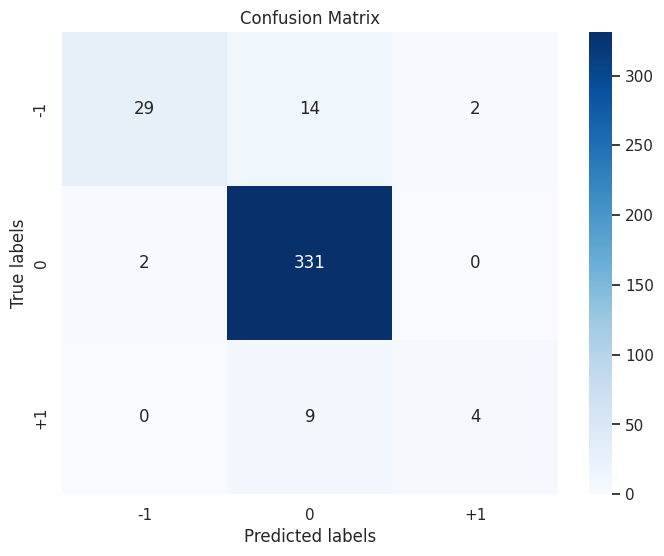

In [101]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_live_data(y_pred):
    pred_result = y_pred[['datetime', 'close', 'prediction']].copy()

    pred_target = get_target_next_close(pred_result)

    # Confusion report
    print("\nClassification Report:\n", classification_report(pred_target['target'], pred_target['prediction']))

    # 1. Confusion Matrix
    conf_matrix = confusion_matrix(pred_target['target'], pred_target['prediction'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['-1', '0', '+1'], 
                yticklabels=['-1', '0', '+1'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_live_data(y_live_pred)

The model performs exceptionally well for the majority class (0.0) but struggles to effectively identify instances of the minority classes (-1.0 and 1.0). High precision but low recall for the minority classes indicates that when the model predicts these classes, it is usually correct, but it also misses a significant number of instances that it should have caught.

In [98]:
# X_live['datetime', 'close', 'prediction']

# print X-live data in these columns 'datetime', 'close', 'prediction'
# print(X_live[['datetime', 'close', 'prediction']])

pred_result = X_live[['datetime', 'close', 'prediction']].copy()

# Calculate future close price, if prediction is 1, then close price will be 1% higher, if prediction is -1, then close price will be 1% lower
pred_result['future_close'] = pred_result['close'] * (1 + pred_result['prediction'] * 0.01)

# add 10 periods to datetime
# pred_result['datetime'] = pred_result['datetime'] + pd.DateOffset(hours=10)

# create empty dataframe, datetime range from last pred_result['datetime'] to 10 periods later
date_range = pd.date_range(start=pred_result['datetime'].iloc[-1], periods=11, freq='H')
# remove first row of date_range
date_range = date_range[1:]

pred_result_future = pd.DataFrame()
pred_result_future['datetime'] = date_range
pred_result_future['close'] = np.nan
pred_result_future['prediction'] = np.nan
pred_result_future['future_close'] = np.nan

# concat pred_result and pred_result_future
pred_result = pd.concat([pred_result, pred_result_future])

# shift future_close 10 periods up
pred_result['future_close'] = pred_result['future_close'].shift(10)


print(pred_result.tail(5))

# plot 2 lines of close and future_close with sns
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
plt.figure(figsize=(30,10))
plt.title('BTCUSDT-1h')
sns.lineplot(data=pred_result, x="datetime", y="close")
sns.lineplot(data=pred_result, x="datetime", y="future_close")

# plot green dot if prediction is 1, red dot if prediction is -1, blue dot if prediction is 0 or nan
plt.scatter(pred_result[pred_result['prediction'] == 1]['datetime'], pred_result[pred_result['prediction'] == 1]['close'], color='green')
plt.scatter(pred_result[pred_result['prediction'] == -1]['datetime'], pred_result[pred_result['prediction'] == -1]['close'], color='red')
# plt.scatter(pred_result[pred_result['prediction'] == 0]['datetime'], pred_result[pred_result['prediction'] == 0]['close'], color='blue')



plt.show()




KeyError: "['prediction'] not in index"

----

----

----

### Experiment 1: Improvement with Feature Engineering

Potential improvements based on feature engineering:

1. **Feature Selection**: 
    - Eliminate redundant or less important features using methods like feature importance, Recursive Feature Elimination (RFE), or correlation matrices.
   
2. **Lagged Features**: 
    - Add past values (lags) of selected features such as closing prices or volumes from recent periods.
   
3. **Additional Moving Averages**: 
    - Incorporate Simple Moving Averages (SMA) and Weighted Moving Averages (WMA).
   
4. **Price Channels**: 
    - Calculate the range between the highest high and the lowest low for a set period.
   
5. **Volume-based Indicators**: 
    - Add more volume indicators, e.g., On-Balance Volume (OBV).
   
6. **Sentiment Analysis**: 
    - If available, use news data or financial reports to derive sentiment scores.
   
7. **Trend Detection**: 
    - Introduce indicators like MACD or Bollinger Bands for trend and breakout detection.
   
8. **Feature Transformation**: 
    - Consider generating polynomial features or interaction terms between significant features.
   
9. **Domain-Specific Features**: 
    - Incorporate features based on domain-specific events such as financial reports or product launches.
   
10. **Rolling Window Statistics**: 
    - Add features capturing statistics over rolling windows, such as mean, median, or standard deviation over the past 'n' periods.
   
11. **External Data**: 
    - Integrate external data points like geopolitical events, interest rates, or inflation rates if they are relevant and available.

In [2]:
import pandas as pd
import warnings

# Ref from data exploration
def remove_outlier(df, iqr_threshold = 5):
    
    # Calculate the first quartile (25th percentile) and third quartile (75th percentile)
    q1 = df['volume'].quantile(0.25)
    q3 = df['volume'].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    lower_bound = 0 if lower_bound < 0 else lower_bound

    # remove outliers from df
    df = df[(df['volume'] > lower_bound) & (df['volume'] < upper_bound)]
    
    return df

def read_hist_data(name = 'BTC', timeframe = '1h'):
    file_path = f"./data/{name}_USDT-{timeframe}.json"
    df = pd.read_json(file_path)

    # set column names
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

    # convert unix timestamp to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    
    df = remove_outlier(df)
    return df

import talib
import numpy as np
import warnings



def get_features(df):
    # df = read_hist_data()

    # List of periods
    periods = [4, 12, 24, 48, 100, 200]
    inputs = ['high', 'low', 'close', 'volume']

    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
            # Generate indicators

            # % of ema
            pct_ema = talib.EMA(df[input].values, timeperiod=period)
            df[f'{input}_ema_{period}'] = (df[input] - pct_ema) / pct_ema * 100

            # RSI
            df[f'{input}_rsi_{period}'] = talib.RSI(df[input].values, timeperiod=period)

            # TRIX
            df[f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            pct_sd = talib.STDDEV(df[input].values, timeperiod=period)
            df[f'{input}_sd_{period}'] = pct_sd / df[input] * 100

            # ROC
            df[f'{input}_roc_{period}'] = talib.ROC(df[input].values, timeperiod=period)

            # VAR
            df[f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)

        
        # Multiple inputs indicators
        # ATR
        pct_atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df[f'price_atr_{period}'] = pct_atr / df['close'] * 100

        # Price interaction Features:
        df[f'price_interact_{period}'] = df[f'close_roc_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df[f'pv_interact_{period}'] = df[f'close_roc_{period}'] * df[f'volume_roc_{period}']

        # ADX
        df[f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df[f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df[f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

    return df

# to predict if the price will go up (+1%) or down (-1%) in the next 10 periods
def get_target_next_close(df, target_shift = 10):
    # df = get_features()

    target_treshold = 0.01
    conditions = [
        (df['close'].shift(target_shift * -1) > df['close'] * (1+target_treshold )),
        (df['close'].shift(target_shift * -1) < df['close'] * (1-target_treshold)),
        (df['close'].shift(target_shift * -1) >= df['close'] * (1-target_treshold)) & 
        (df['close'].shift(target_shift * -1) <= df['close'] * (1+target_treshold))
    ]
    values = [1, -1, 0]
    df['target'] = np.select(conditions, values)
    df = df.dropna()
    return df

def get_features_target_next_close():

    # Disable the PerformanceWarning temporarily
    warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

    df = read_hist_data()
    df = get_features(df)
    df = get_target_next_close(df)

    # Re-enable warnings
    warnings.resetwarnings()

    return df

df = get_features_target_next_close()

print(df.head(5))
print(df.tail(5))

               datetime      open      high       low     close       volume  \
598 2021-01-25 22:00:00  32715.53  32732.99  31910.00  32462.36  3761.903244   
599 2021-01-25 23:00:00  32462.38  32650.00  32201.44  32254.20  2777.021592   
600 2021-01-26 00:00:00  32254.19  32793.01  31758.00  32474.33  3799.041198   
601 2021-01-26 01:00:00  32474.34  32827.33  32210.01  32758.85  2324.035401   
602 2021-01-26 02:00:00  32754.20  32765.41  32230.29  32307.97  2168.256682   

     high_ema_4  high_rsi_4  high_trix_4  high_sd_4  ...  volume_sd_200  \
598   -1.716759    8.849644    -0.469483   1.183593  ...      60.338045   
599   -1.188915    8.175968    -0.579663   1.194198  ...      81.760970   
600   -0.455044   21.845644    -0.576277   0.987855  ...      59.764852   
601   -0.210814   25.399214    -0.506497   0.205008  ...      97.677414   
602   -0.239807   22.894982    -0.426357   0.203295  ...     104.561341   

     volume_roc_200  volume_var_200  price_atr_200  price_interact_2

#### Feature Selection

We use the `feature_importances_` attribute of the RandomForestClassifier to rank the features in previous experiments. We can use this information to eliminate redundant or less important features.

- Change periods to factor of 6 hour
- Remove high, low in general indicators since it is highly correlated with close.
- Remove EMA, RSI and TRIX since they score low in feature importance.

In [50]:
def get_features_v2(df):
    # df = read_hist_data()

    # List of periods
    periods = [6, 12, 24, 48, 96, 192]
    inputs = ['close', 'volume']

    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
            # Generate indicators

            # SD
            pct_sd = talib.STDDEV(df[input].values, timeperiod=period)
            df[f'{input}_sd_{period}'] = pct_sd / df[input] * 100

            # ROC
            df[f'{input}_roc_{period}'] = talib.ROC(df[input].values, timeperiod=period)

            # VAR
            df[f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)

        
        # Multiple inputs indicators
        # ATR
        pct_atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df[f'price_atr_{period}'] = pct_atr / df['close'] * 100

        # Price interaction Features:
        df[f'price_interact_{period}'] = df[f'close_roc_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df[f'pv_interact_{period}'] = df[f'close_roc_{period}'] * df[f'volume_roc_{period}']

        # ADX
        df[f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df[f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df[f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

  
    
    return df

def get_features_v2_target_next_close():

    # Disable the PerformanceWarning temporarily
    warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

    df = read_hist_data()
    df = get_features_v2(df)
    df = get_target_next_close(df)

    # Re-enable warnings
    warnings.resetwarnings()

    return df

df = get_features_v2_target_next_close()

In [5]:
print(df.head(5))
print(df.tail(5))

               datetime      open      high       low     close       volume  \
383 2021-01-16 23:00:00  36127.20  36480.00  35900.00  35994.98  2759.380728   
384 2021-01-17 00:00:00  35994.98  36472.72  35520.00  36396.42  3726.445506   
385 2021-01-17 01:00:00  36396.42  36727.26  36176.66  36715.63  2847.948884   
386 2021-01-17 02:00:00  36715.63  36744.05  36235.00  36419.68  1927.694738   
387 2021-01-17 03:00:00  36419.68  36541.88  35978.00  36177.00  2021.331779   

     close_sd_6  close_roc_6    close_var_6  volume_sd_6  ...  volume_sd_192  \
383    0.777017    -2.349341   78224.895833    38.977953  ...     125.000455   
384    0.742015    -0.242648   72936.039859    24.991390  ...      92.593249   
385    0.873052     0.932583  102750.147259    34.988291  ...     121.295548   
386    0.755132    -0.793982   75634.248659    61.733118  ...     179.439558   
387    0.654544     0.703031   56071.652615    33.356096  ...     171.101828   

     volume_roc_192  volume_var_192  p

In [198]:
from sklearn.model_selection import train_test_split

df = get_features_v2_target_next_close()
drop_cols = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

In [199]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=55, n_jobs=-1) # n_jobs=-1 to use all cores
model.fit(X_train, y_train)

importances = model.feature_importances_

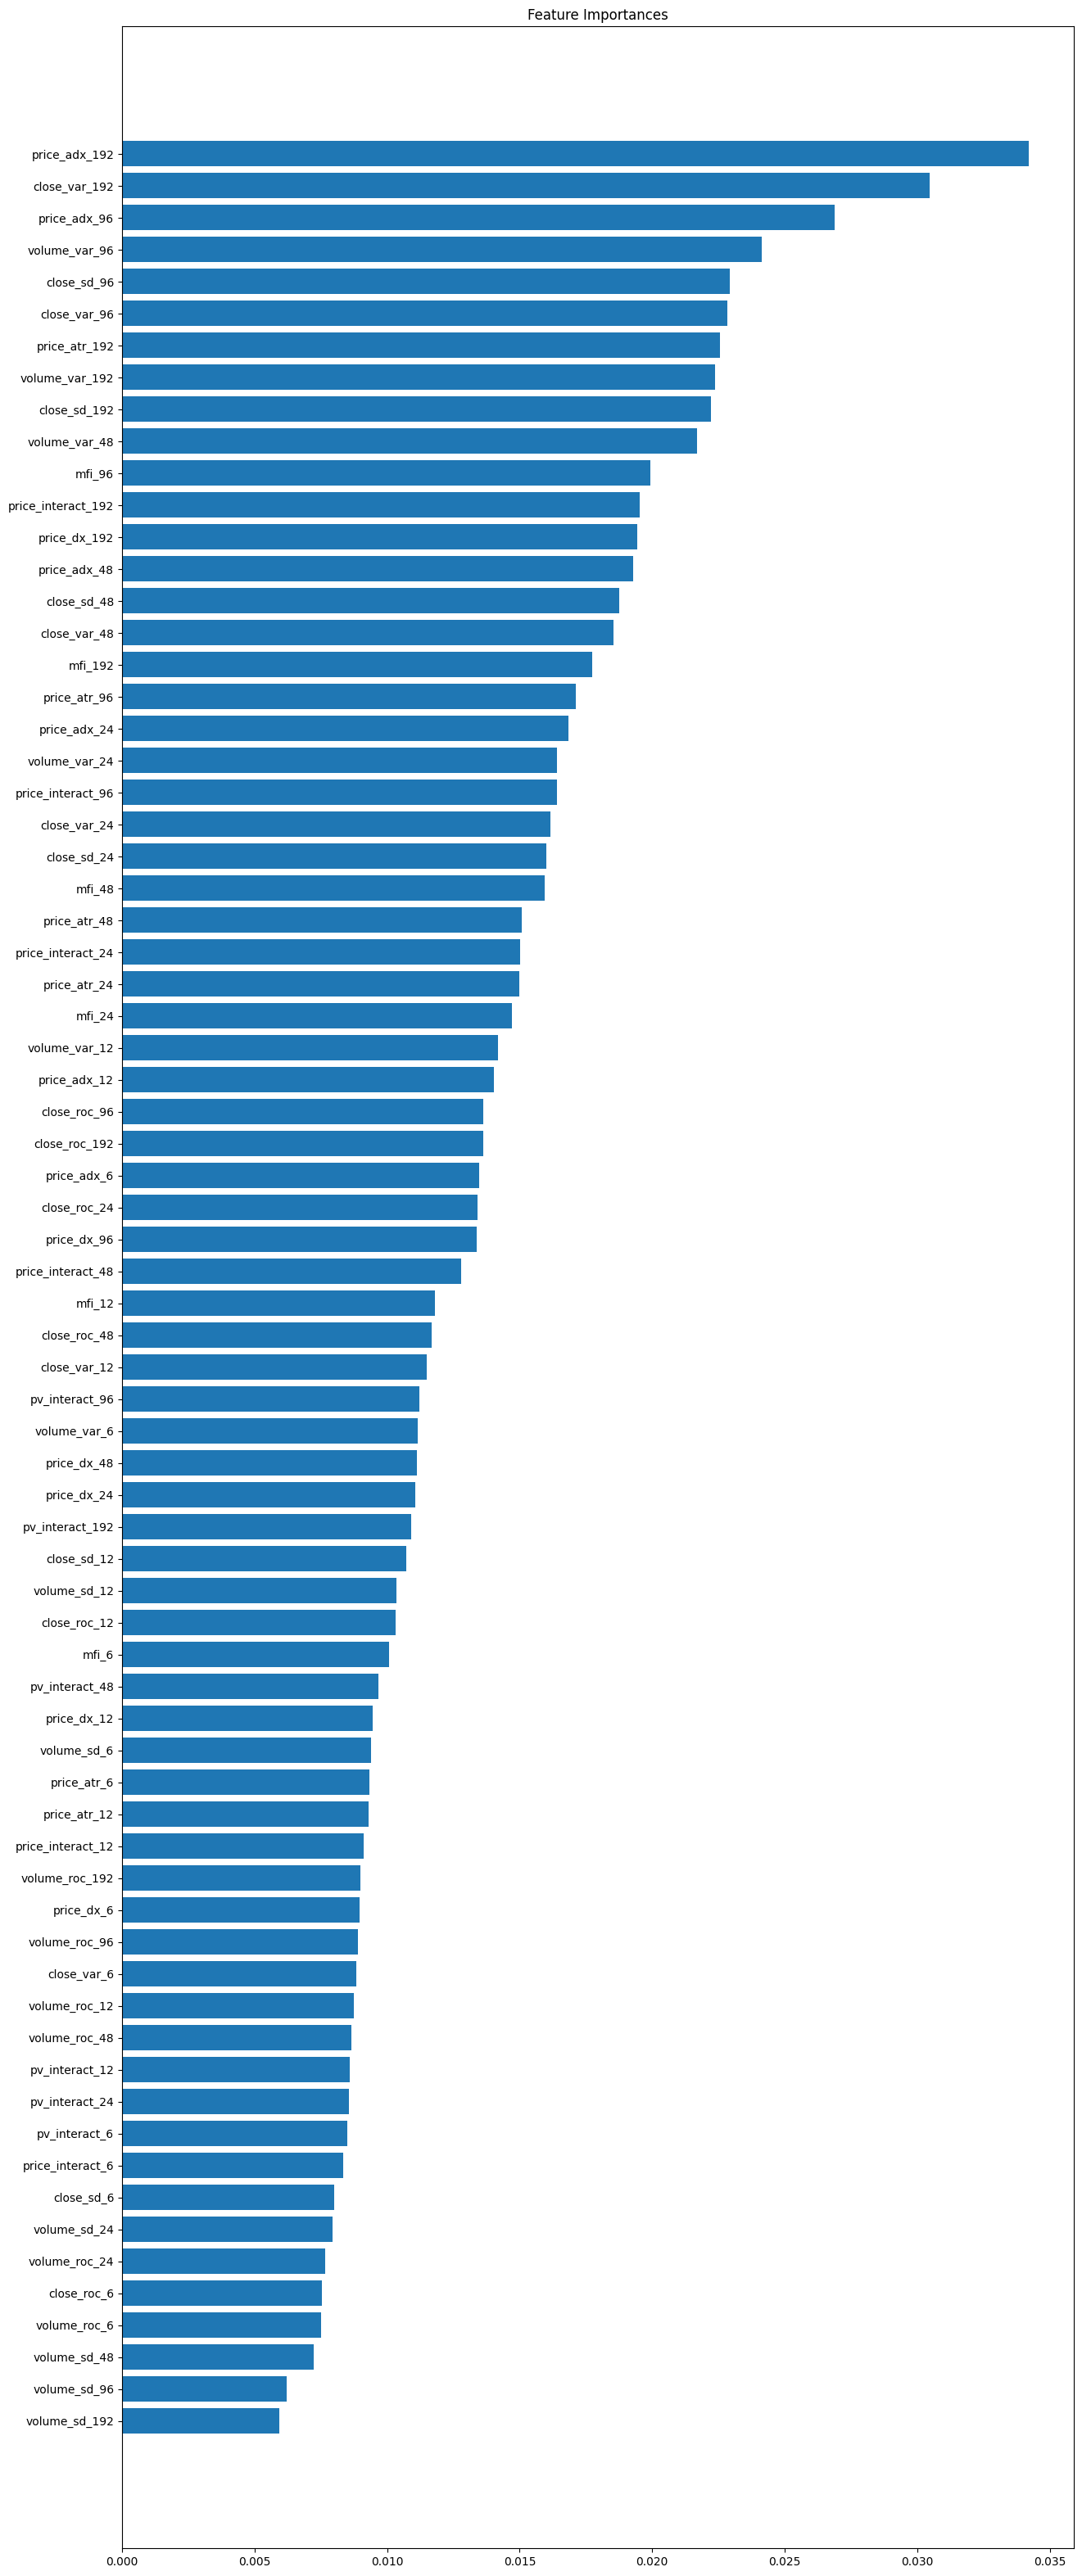

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 40))
plt.title("Feature Importances")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Pre-processing



In [201]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb

random_state = 55

# Base models
estimators = [
    ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)),
    ('LightGBM', lgb.LGBMClassifier(n_estimators=100, random_state=random_state, n_jobs=-1, verbose=-1)),
    ('BaggingForest', BaggingClassifier(estimator=RandomForestClassifier(n_estimators=10, random_state=random_state), n_estimators=10, random_state=random_state, n_jobs=-1)),
    ('BaggingTree', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=random_state, n_jobs=-1)),
    ('NaiveBayes', GaussianNB())
]

# Stacking Logistic Classifier
stacking_logistic_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1)

# Full pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=random_state)),
    ('model', stacking_logistic_model)
])


In [202]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=55)),
                ('model',
                 StackingClassifier(estimators=[('RandomForest',
                                                 RandomForestClassifier(n_jobs=-1,
                                                                        random_state=55)),
                                                ('LightGBM',
                                                 LGBMClassifier(n_jobs=-1,
                                                                random_state=55,
                                                                verbose=-1)),
                                                ('BaggingForest',
                                                 BaggingClassifier(estimator=RandomForestClassifier(n_estimators=10,
                                                                                                    random_state=55),
                                                                   n_jobs=-1,
                                                                   random_state=55)),
                                                ('BaggingTree',
                                                 BaggingClassifier(estimator=DecisionTreeClassifier(),
                                                                   n_jobs=-1,
                                                                   random_state=55)),
                                                ('NaiveBayes', GaussianNB())],
                                    final_estimator=LogisticRegression(max_iter=10000),
                                    n_jobs=-1))])

In [203]:
y_pred = pipeline.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

          -1       0.80      0.75      0.77      1519
           0       0.80      0.84      0.82      3629
           1       0.80      0.75      0.77      1612

    accuracy                           0.80      6760
   macro avg       0.80      0.78      0.79      6760
weighted avg       0.80      0.80      0.80      6760



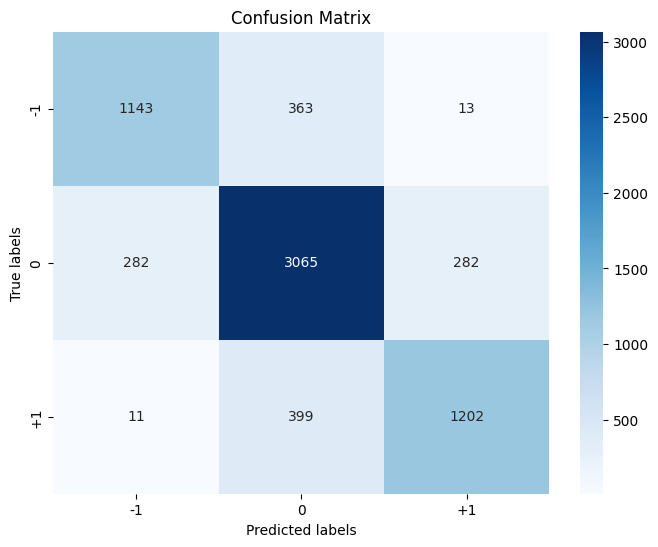

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion report
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['-1', '0', '+1'], 
            yticklabels=['-1', '0', '+1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


#### Summary of Feature Refinement and Model Results:

1. **Feature Selection**:
    - In the revised `get_features_v2` function, the features have been simplified.
    - The number of periods for generating features has been slightly adjusted: `[6, 12, 24, 48, 96, 192]`.
    - Only two main inputs, `close` and `volume`, are used to derive features as opposed to the previous list which included `high`, `low`, `close`, and `volume`.
    - A set of specific technical indicators (`SD`, `ROC`, `VAR`, `ATR`, interaction features, `ADX`, `MFI`, `DX`) have been retained. This streamlined selection could potentially reduce noise and the risk of overfitting.

2. **Model Performance**:
    - **Accuracy**: Improved by 1% to 80% from the previous 79%.
    - **Precision, Recall, and F1-score**: All three metrics show a consistent score of around 0.80 across the classes.
        - **Class -1**: Predicts price decreases > -1% of the current close with a precision of 0.80 and recall of 0.75.
        - **Class 0**: Predicts price changes between +- 1% of the current close with a precision of 0.80 and recall of 0.84.
        - **Class 1**: Predicts price increases > +1% of the current close with a precision of 0.80 and recall of 0.75.

3. **Conclusions**:
    - The feature refinement resulted in a model with a more focused set of features.
    - Model performance improved slightly, which indicates that the refined feature set may be capturing the most influential patterns in the data without unnecessary noise.
    - This demonstrates the potential power of effective feature engineering – **sometimes fewer, more meaningful features can lead to better model performance.**

Next Steps:
- Further hyperparameter tuning can be performed with the new feature set to possibly achieve even better results.

----

### Experiment X: Pre-processing refinements

We did pre-processing with SMOTE and StandardScaler. We can try to remove them and see if it improves the model.



----

### Experiment 2: Hyperparameter Tuning

In [206]:
from sklearn.model_selection import train_test_split

df = get_features_v2_target_next_close()
drop_cols = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

In [207]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb

random_state = 55

# Base models
estimators = [
    ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)),
    ('LightGBM', lgb.LGBMClassifier(n_estimators=100, random_state=random_state, n_jobs=-1, verbose=-1)),
    ('BaggingForest', BaggingClassifier(estimator=RandomForestClassifier(n_estimators=10, random_state=random_state), n_estimators=10, random_state=random_state, n_jobs=-1)),
    ('BaggingTree', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=random_state, n_jobs=-1)),
    ('NaiveBayes', GaussianNB())
]

# Stacking Logistic Classifier
stacking_logistic_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=10000), n_jobs=-1)

# Full pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=random_state)),
    ('model', stacking_logistic_model)
])


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the grid of hyperparameters to search
param_grid = {
    # Random Forest parameters
    'model__RandomForest__n_estimators': [50, 100, 150],
    'model__RandomForest__max_depth': [None, 10, 20, 30],
    'model__RandomForest__min_samples_split': [2, 5, 10],

    # LightGBM parameters
    'model__LightGBM__n_estimators': [50, 100, 150],
    'model__LightGBM__learning_rate': [0.01, 0.05, 0.1],
    'model__LightGBM__num_leaves': [31, 62, 124],

    # BaggingForest parameters
    'model__BaggingForest__n_estimators': [5, 10, 15],

    # BaggingTree parameters
    'model__BaggingTree__n_estimators': [5, 10, 15],

    # SMOTE parameters
    'smote__sampling_strategy': ['auto', 0.5, 0.75],

    # StackingClassifier final estimator (Logistic Regression) parameters
    'model__final_estimator__C': [0.01, 0.1, 1, 10],
    'model__final_estimator__solver': ['lbfgs', 'sag']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the model (this might take a while given the number of combinations)
# X_train and y_train should be your training data and labels, respectively
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)


The optimization has been running more than 24 hours and still not finished. I decided to stop the optimization and use the best parameters found so far.

#### Alternative ways to speed up the process:

##### 1. Randomized Search

Instead of an exhaustive grid search, use a randomized search. It samples a fixed number of parameter combinations from the specified hyperparameter space. This can be more efficient and quicker.

```python
from sklearn.model_selection import RandomizedSearchCV

# Use RandomizedSearchCV instead of GridSearchCV
rand_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=50, scoring='accuracy', n_jobs=-1)
```

##### 2. Coarse-to-Fine Tuning

First perform a rough search over a wide range of parameter values, and then perform a more focused search around the best parameters found.

##### 3. Parallelization

Increase the number of workers in the search, setting `n_jobs=-1` will use all available CPUs to perform the search.

##### 4. Early Stopping

For algorithms that support it (e.g., gradient boosting, neural networks), you can set early stopping rules to halt the training process when it's clear the model is not improving.

##### 5. Bayesian Optimization

This is a probabilistic model based optimization technique, and is more efficient than grid and random search. Libraries like `Hyperopt` or `Optuna` can be used for Bayesian Optimization.

##### 6. Reduce Data Size

For a quicker run time, you can perform the hyperparameter tuning steps on a smaller subset of your data. Once the best parameters are found, you can use them to train the model on the complete dataset.

##### 7. Incremental Training

If your model allows for incremental training (also known as "warm starting"), you can train it in chunks to allow for more iterative model updates.

##### 8. Pre-emption

Some optimization frameworks allow you to preemptively halt the least promising trials before they complete, based on interim results.

##### 9. Ensemble of Best Models

Instead of searching for one set of optimal parameters, you can train multiple models with different parameters and ensemble their predictions.

##### 10. Checkpointing

Save the model and its best parameters periodically during training, so you can stop and restart the optimization process at will.

It may be advisable to use a combination of these techniques to speed up your hyperparameter search effectively.

----

### Experiment 3: Hyperparameter Tuning with Ensemble of Best Models Approach

Long running times during hyperparameter optimization are common, especially when the parameter space is large and the model is complex. I decide to use the ensemble of best models approach to spit the hyperparameter tuning into multiple runs. Then I will stack the best models from each run to form the final model.

In [6]:
from sklearn.model_selection import train_test_split

df = get_features_v2_target_next_close()
drop_cols = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

In [15]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb
from sklearn.metrics import classification_report

random_state = 55

# Base models
estimators = [
    ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)),
    ('LightGBM', lgb.LGBMClassifier(n_estimators=100, random_state=random_state, n_jobs=-1, verbose=-1)),
    ('BaggingForest', BaggingClassifier(estimator=RandomForestClassifier(n_estimators=10, random_state=random_state), n_estimators=10, random_state=random_state, n_jobs=-1)),
    ('BaggingTree', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=random_state, n_jobs=-1)),
    ('NaiveBayes', GaussianNB())
]

**Step 1: Train Each Base Model Separately and Save Best Parameters**

1.1 RandomForestClassifier

In [24]:
from sklearn.model_selection import GridSearchCV

# Parameter grid for RandomForest
param_grid_rf = {'n_estimators': [50, 100, 150, 200, 250, 300, 350], 'max_depth': [None, 10, 20, 30, 40, 50]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=random_state, n_jobs=-1), param_grid=param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)

# Save best parameters
best_params_rf = grid_rf.best_params_
print("Best Parameters for RandomForest:", best_params_rf)


Best Parameters for RandomForest: {'max_depth': 30, 'n_estimators': 350}


In [25]:
# predict with original model
model = RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = RandomForestClassifier(**best_params_rf, random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))





Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.81      0.64      0.72      1519
           0       0.75      0.88      0.81      3629
           1       0.82      0.65      0.73      1612

    accuracy                           0.77      6760
   macro avg       0.79      0.72      0.75      6760
weighted avg       0.78      0.77      0.77      6760


Classification Report (Best Model):
               precision    recall  f1-score   support

          -1       0.83      0.65      0.73      1519
           0       0.75      0.89      0.82      3629
           1       0.83      0.66      0.74      1612

    accuracy                           0.78      6760
   macro avg       0.80      0.73      0.76      6760
weighted avg       0.79      0.78      0.78      6760



1.2 LightGBM

In [30]:
# Suppress the DeprecationWarning temporarily
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Parameter grid for LightGBM
param_grid_lgb = {'n_estimators': [50, 100, 150, 200, 250], 'learning_rate': [0.01, 0.05, 0.1], 'num_leaves': [31, 62, 124]}
grid_lgb = GridSearchCV(lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1), param_grid=param_grid_lgb, cv=5)
grid_lgb.fit(X_train, y_train)

# Save best parameters
best_params_lgb = grid_lgb.best_params_
print("Best Parameters for RandomForest:", best_params_lgb)


Best Parameters for RandomForest: {'learning_rate': 0.1, 'n_estimators': 250, 'num_leaves': 124}


In [32]:
# predict with original model
model = lgb.LGBMClassifier(n_estimators=100, random_state=random_state, n_jobs=-1, verbose=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = lgb.LGBMClassifier(**best_params_lgb, random_state=random_state, n_jobs=-1, verbose=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))

# Re-enable warnings
warnings.resetwarnings()


Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.76      0.52      0.62      1519
           0       0.70      0.88      0.78      3629
           1       0.76      0.56      0.64      1612

    accuracy                           0.72      6760
   macro avg       0.74      0.65      0.68      6760
weighted avg       0.73      0.72      0.71      6760


Classification Report (Best Model):
               precision    recall  f1-score   support

          -1       0.81      0.70      0.75      1519
           0       0.78      0.88      0.83      3629
           1       0.84      0.70      0.76      1612

    accuracy                           0.80      6760
   macro avg       0.81      0.76      0.78      6760
weighted avg       0.80      0.80      0.79      6760



1.3 BaggingForest

In [39]:
warnings.filterwarnings("ignore", category=UserWarning)

# Parameter grid for BaggingForest
param_grid_bf = {'n_estimators': [10, 25, 50, 100]}
# Reuse the best parameters for RandomForest
grid_bf = GridSearchCV(BaggingClassifier(
        estimator=RandomForestClassifier(**best_params_rf, random_state=random_state), 
        random_state=random_state, n_jobs=-1), param_grid=param_grid_bf, cv=5)

grid_bf.fit(X_train, y_train)

# Save best parameters
best_params_bf = grid_bf.best_params_
print("Best Parameters for BaggingForest:", best_params_bf)

Best Parameters for BaggingForest: {'n_estimators': 50}


In [38]:
# predict with original model
model = BaggingClassifier(estimator=RandomForestClassifier(n_estimators=10, random_state=random_state), n_estimators=10, random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = BaggingClassifier(estimator=RandomForestClassifier(**best_params_rf, random_state=random_state), **best_params_bf, random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))

# Re-enable warnings
warnings.resetwarnings()


Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.82      0.53      0.64      1519
           0       0.70      0.90      0.79      3629
           1       0.79      0.54      0.64      1612

    accuracy                           0.73      6760
   macro avg       0.77      0.66      0.69      6760
weighted avg       0.75      0.73      0.72      6760


Classification Report (Best Model):
               precision    recall  f1-score   support

          -1       0.84      0.54      0.65      1519
           0       0.71      0.91      0.80      3629
           1       0.81      0.57      0.67      1612

    accuracy                           0.74      6760
   macro avg       0.79      0.67      0.71      6760
weighted avg       0.76      0.74      0.73      6760



1.4 BaggingTree

In [40]:
# Parameter grid for DecisionTreeClassifier
param_grid_dt = {'max_depth': [None, 10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10], 'n_estimators': [10, 25, 50, 100, 150, 200]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=random_state), param_grid=param_grid_dt, cv=5)
grid_dt.fit(X_train, y_train)

# Save best parameters
best_params_dt = grid_dt.best_params_
print("Best Parameters for DecisionTreeClassifier:", best_params_dt)

Best Parameters for DecisionTreeClassifier: {'max_depth': None}


In [42]:
# Parameter grid for BaggingTree
param_grid_bt = {'n_estimators': [10, 25, 50, 100, 150, 200]}
# Reuse the best parameters for DecisionTreeClassifier
grid_bt = GridSearchCV(BaggingClassifier(
        estimator=DecisionTreeClassifier(**best_params_dt, random_state=random_state), 
        random_state=random_state, n_jobs=-1), param_grid=param_grid_bt, cv=5)

grid_bt.fit(X_train, y_train)

# Save best parameters
best_params_bt = grid_bt.best_params_
print("Best Parameters for BaggingTree:", best_params_bt)

Best Parameters for BaggingTree: {'n_estimators': 150}


In [43]:
# predict with original model
model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = BaggingClassifier(estimator=DecisionTreeClassifier(**best_params_dt, random_state=random_state), **best_params_bt, random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.67      0.62      0.64      1519
           0       0.73      0.83      0.77      3629
           1       0.73      0.57      0.64      1612

    accuracy                           0.72      6760
   macro avg       0.71      0.67      0.69      6760
weighted avg       0.72      0.72      0.71      6760


Classification Report (Best Model):
               precision    recall  f1-score   support

          -1       0.82      0.66      0.73      1519
           0       0.76      0.88      0.82      3629
           1       0.82      0.68      0.74      1612

    accuracy                           0.78      6760
   macro avg       0.80      0.74      0.76      6760
weighted avg       0.79      0.78      0.78      6760



1.5 NaiveBayes

In [44]:
# Parameter grid for NiaveBayes
param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
grid_nb = GridSearchCV(GaussianNB(), param_grid=param_grid_nb, cv=5)
grid_nb.fit(X_train, y_train)

# Save best parameters
best_params_nb = grid_nb.best_params_
print("Best Parameters for GaussianNB:", best_params_nb)


Best Parameters for GaussianNB: {'var_smoothing': 1e-08}


In [45]:
# predict with original model
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = GaussianNB(**best_params_nb)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))



Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.38      0.05      0.09      1519
           0       0.56      0.92      0.69      3629
           1       0.31      0.11      0.16      1612

    accuracy                           0.53      6760
   macro avg       0.42      0.36      0.31      6760
weighted avg       0.46      0.53      0.43      6760


Classification Report (Best Model):
               precision    recall  f1-score   support

          -1       0.40      0.05      0.10      1519
           0       0.56      0.92      0.69      3629
           1       0.32      0.11      0.16      1612

    accuracy                           0.53      6760
   macro avg       0.42      0.36      0.32      6760
weighted avg       0.46      0.53      0.43      6760



In [59]:
# predict with NeuralNetwork
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(random_state=random_state)
# apply SMOTE to training data
X_train_smote, y_train_smote = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))



Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.27      0.38      0.32      1519
           0       0.58      0.20      0.30      3629
           1       0.27      0.57      0.37      1612

    accuracy                           0.33      6760
   macro avg       0.37      0.38      0.33      6760
weighted avg       0.44      0.33      0.32      6760



1.7 LogisticRegression

1.6 SVM non-linear

In [11]:
df = get_features_target_next_close()

from sklearn.model_selection import train_test_split

df = get_features_v2_target_next_close()
drop_cols = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

random_state = 55

# Parameter grid for SVM non-linear
param_grid_svm = {'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10]}
grid_svm = GridSearchCV(SVC(kernel='rbf', random_state=random_state), param_grid=param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)

# Save best parameters
best_params_svm = grid_svm.best_params_
print("Best Parameters for SVM non-linear:", best_params_svm)


KeyboardInterrupt: 

In [58]:


# predict with original model
model = SVC(kernel='rbf' , random_state=random_state)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = SVC(kernel='rbf', **best_params_svm, random_state=random_state)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))



Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.49      0.07      0.11      1519
           0       0.55      0.98      0.70      3629
           1       0.57      0.02      0.03      1612

    accuracy                           0.55      6760
   macro avg       0.54      0.36      0.28      6760
weighted avg       0.54      0.55      0.41      6760


Classification Report (Best Model):
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1519
           0       0.54      1.00      0.70      3629
           1       0.00      0.00      0.00      1612

    accuracy                           0.54      6760
   macro avg       0.18      0.33      0.23      6760
weighted avg       0.29      0.54      0.38      6760



**Step 2: Create Best Models Using Saved Parameters**

In [ ]:
best_rf = RandomForestClassifier(**best_params_rf)
best_lgbm = lgb.LGBMClassifier(**best_params_lgbm)
best_bagging_forest = BaggingClassifier(**best_params_bagging_forest)
best_bagging_tree = BaggingClassifier(**best_params_bagging_tree)
best_naive_bayes = GaussianNB(**best_params_naive_bayes)

----

In [40]:
#### Old data

df = get_features_v2_target_next_close()

from sklearn.model_selection import train_test_split

df = get_features_v2_target_next_close()
drop_cols = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df['target']

random_state = 55

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [41]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# # apply SMOTE to training data
# X_train_smote, y_train_smote = SMOTE(random_state=random_state).fit_resample(X_train_scaled, y_train)

X_train_smote, y_train_smote = SMOTE(random_state=random_state).fit_resample(X_train, y_train)


In [42]:
from sklearn.neural_network import MLPClassifier


# model = MLPClassifier(random_state=random_state)
model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=10000, random_state=55)

model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.29      0.46      0.36      1519
           0       0.70      0.10      0.17      3629
           1       0.26      0.62      0.36      1612

    accuracy                           0.30      6760
   macro avg       0.42      0.39      0.30      6760
weighted avg       0.50      0.30      0.26      6760



In [43]:
model = SVC(kernel='poly' , random_state=random_state)
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.24      0.83      0.37      1519
           0       0.69      0.22      0.34      3629
           1       0.39      0.09      0.14      1612

    accuracy                           0.33      6760
   macro avg       0.44      0.38      0.28      6760
weighted avg       0.51      0.33      0.30      6760



In [44]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.39      0.08      0.13      1519
           0       0.56      0.90      0.69      3629
           1       0.31      0.12      0.17      1612

    accuracy                           0.53      6760
   macro avg       0.42      0.37      0.33      6760
weighted avg       0.46      0.53      0.44      6760


Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.38      0.05      0.09      1519
           0       0.56      0.92      0.69      3629
           1       0.31      0.11      0.16      1612

    accuracy                           0.53      6760
   macro avg       0.42      0.36      0.31      6760
weighted avg       0.46      0.53      0.43      6760



In [49]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with original model
model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=random_state, n_jobs=-1)
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.67      0.62      0.64      1519
           0       0.73      0.83      0.77      3629
           1       0.73      0.57      0.64      1612

    accuracy                           0.72      6760
   macro avg       0.71      0.67      0.69      6760
weighted avg       0.72      0.72      0.71      6760


Classification Report (Original Model):
               precision    recall  f1-score   support

          -1       0.65      0.73      0.69      1519
           0       0.79      0.76      0.77      3629
           1       0.73      0.71      0.72      1612

    accuracy                           0.74      6760
   macro avg       0.72      0.73      0.73      6760
weighted avg       0.74      0.74      0.74      6760

